### Image Signal Processor (ISP) Project Overview

In this project, a basic Image Signal Processor (ISP) is developed that converts raw sensor images into vibrant color images. The task involves processing raw binary files containing sensor data and applying a series of image processing techniques to achieve the final output.

Steps:
- **Reading the image**: Start by interpreting the raw binary data to extract the sensor information.
- **Demosaicing**: Convert the raw sensor data into RGB format, enabling the creation of a full-color image.
- **Color Correction**: Using a matrix, adjust the colors to ensure accuracy and natural appearance.
- **Denoising**: Apply a bilateral filter to reduce noise while preserving important details in the image.
- **Edge Enhancement**: Utilize an unsharp mask to enhance the edges, making the image crisper and more defined.
- **Contrast Enhancement**: Finally, use CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve the contrast, bringing out details in both the shadows and highlights.

The final result was a color-corrected, noise-reduced, sharp, and well-contrasted image, saved to an output file for further use.


In [1]:
# Import libraries
#%matplotlib inline
import os
import os.path as op

import numpy as np
import cv2 # OpenCV
from skimage import exposure # SciKit-Image for image processing
from scipy import ndimage
import matplotlib.pylab as plt


ModuleNotFoundError: No module named 'matplotlib'

## Reading the Raw Image File

FIrstly, start by reading in a raw image file. This file is an image of an "imatest" photographic test chart, stored as unsigned integers with 8 bits per pixel (i.e. bit depth). The process involves reading the binary data and then reshaping it into the appropriate image dimensions (in this case, 4096*2160 pixels).


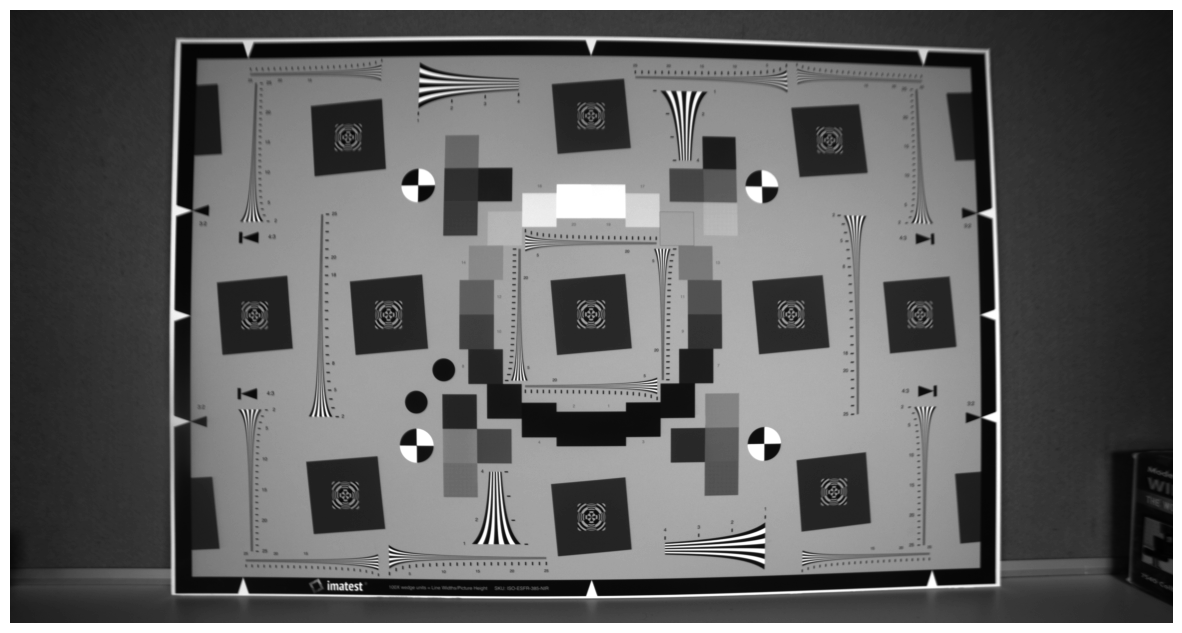

In [ ]:
# Raw file details:
# width - 4096
# height - 2160
# bit depth - 8
# Bayer pattern - rggb


bayer_width = 4096
bayer_height = 2160

raw_path = 'images/chart.raw'

bayer = np.fromfile(raw_path, dtype='uint8', sep='') # Create array from binary file

bayer = bayer.reshape((bayer_height, bayer_width)) # Reshape array to 2D image

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer,cmap=plt.get_cmap('gray')) 
plt.axis('off')
plt.show()


Next, the RAW file is simply read in and displayed to its full dimensions. 

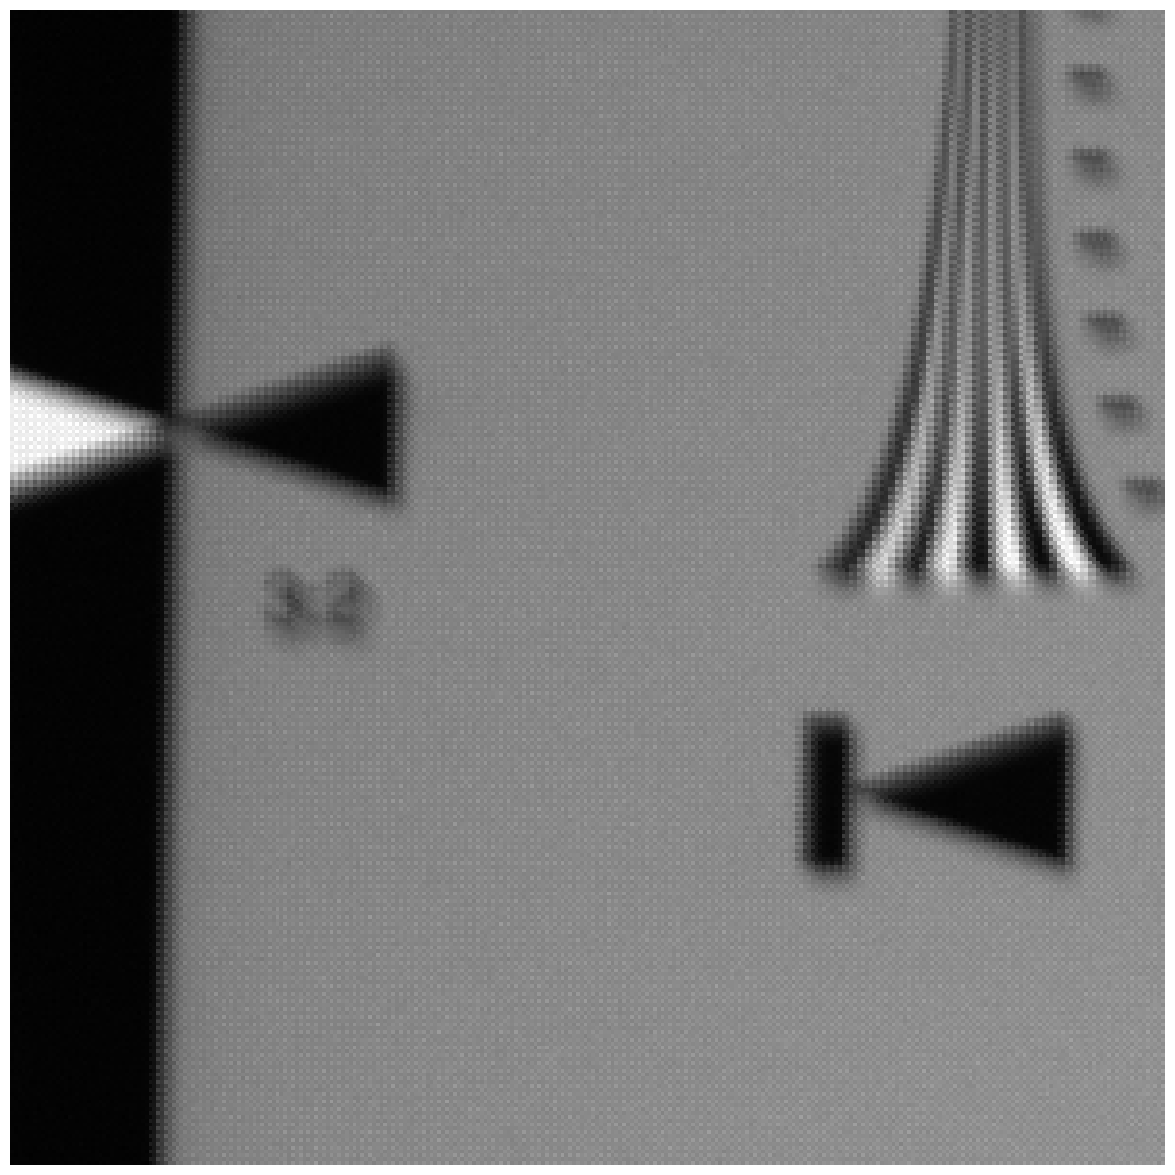

In [ ]:
# crop and show a small area, to show the Bayer raw pattern
bayer_crop = bayer[600:900, 600:900] 

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer_crop,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

## Comments
What can be seen is the greyscale (raw) bayer filter pattern. 

## Demosaic the image
The demosaic process converts raw pixel data into RGB image data. Each raw sensor pixel contains only one colour. Part of the demosaic process is to use interpolation to generate the missing colours for each pixel (i.e. a red pixel will get green and blue pixel information from the neighbouring pixels

The opencv "cvtColor" function is used which can convert between many colour spaces. Docs: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

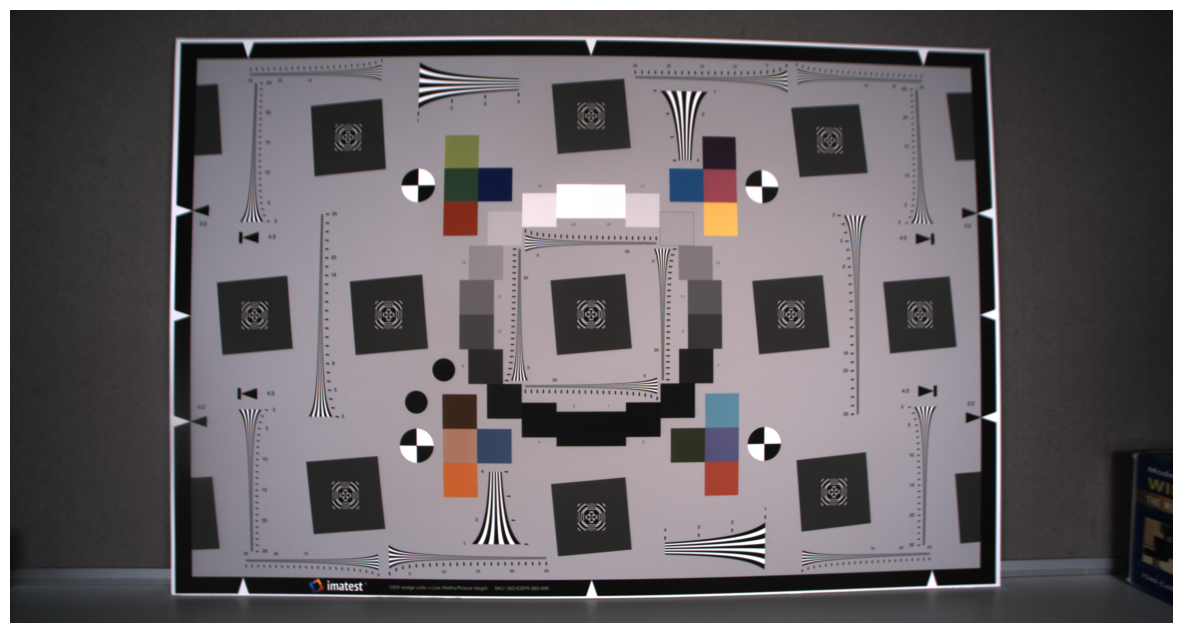

In [ ]:
# Demosaic the image (i.e. covert from raw image to RGB)
raw_image = np.fromfile(raw_path, dtype=np.uint8)
raw_image = raw_image.reshape((bayer_height, bayer_width))

bayer_pattern = cv2.COLOR_BayerRG2BGR 

rgb_image = cv2.cvtColor(raw_image, bayer_pattern)

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()



## Comments
Demosaicing the image by converting the RAW image data to RGB provides color, but is lacking in vibrance. This is due to the lack of color correction.

## Apply colour correction

A colour correction matrix is applied to improve colour reproduction accuracy. If you notice, red appears too orange before
correction is applied.

The colour correction matrix (CCM) is calculated during the camera development phase, and varies from camera to camera.

For simplicity, the CCM for this particular camera is provided below:
    
    [[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]]
    
 
 This 3*3 matrix is multiplied by the RGB values for every pixel
 
 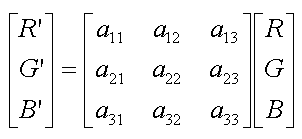
 
 
 
 For embedded applications, floating point numbers are avoided wherever possible. In this example, the base is 1024 (i.e. to convert to floating point, divide the CCM by 1024)
 
 To apply the CCM in this example, the following steps are required:
 - cast the image to np.int32
 - multiply the RGB pixel data by the 3*3 CCM
 - divide by 1024 (note: this can be done by explicit division or right_shift by 10).
 - re-cast the image back to np.uint8
    

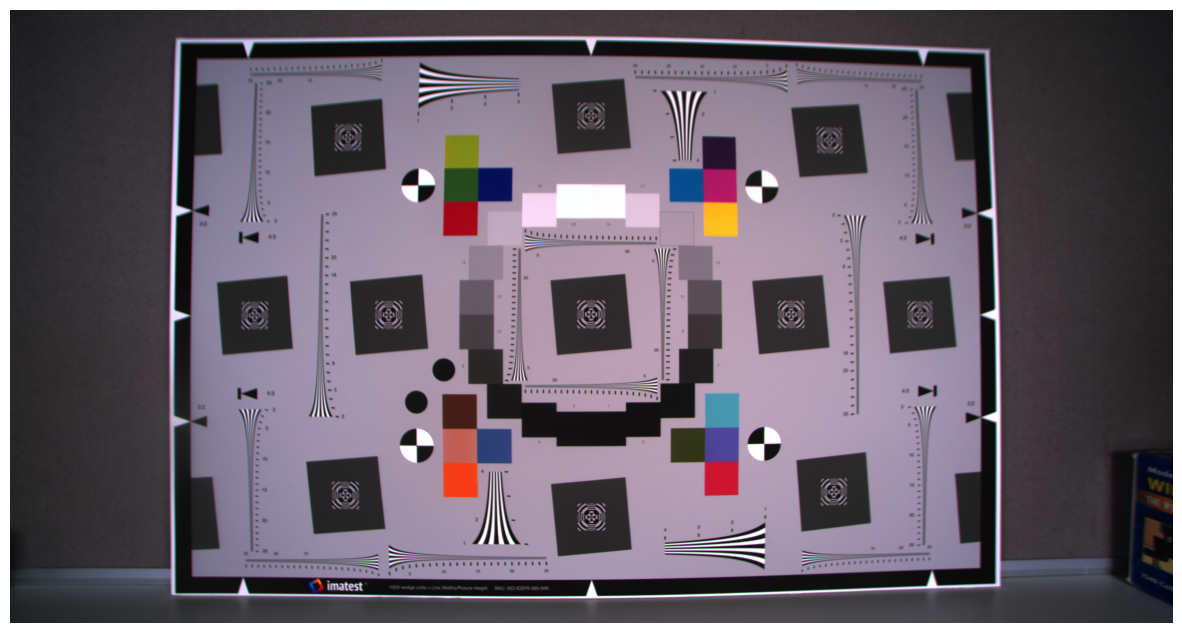

In [ ]:
# Create colour correction matrix
# note: to avoid clipping, we have to temporarily cast our image data to int32, and then return to 8 bit
ccm = np.array([[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]],dtype=np.int32).T

# multiply the image by the ccm matrix, and then use np.right_shift to scale the image down to the 8 bit range again
# use the np.clip function to ensure the data range is within 0 and 255

#   cast the ccm array and image as np.int32
int32_rgb_image = rgb_image.astype(np.int32)
cc_rgb_image = int32_rgb_image.dot(ccm)

#   scale the image back to 8 bit, automatically re-casting as np.uint8 and clipping to 0-255
cc_rgb_image = np.right_shift(cc_rgb_image, 10).clip(0,255).astype(np.uint8)

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(cc_rgb_image)
plt.axis('off')
plt.show()



## Comments
In review, the color correction matrix is multiplied by dot product with the RGB image. Both are first cast to 32bit unsigned integers to avoid color clipping. The image is right bit-shifted to 8 bit, the right_shift method casts it back to UInt8 automagically, and it is clipped between 0 and 255. The resulting colors are much more vibrant and accurate to the real-world. 

## Apply gamma correction

Gamma correction is applied using the following formula:

$$
outputImage = ((inputImage / 255)^\gamma) * 255
$$

Typically, $$\gamma=1/2.2$$


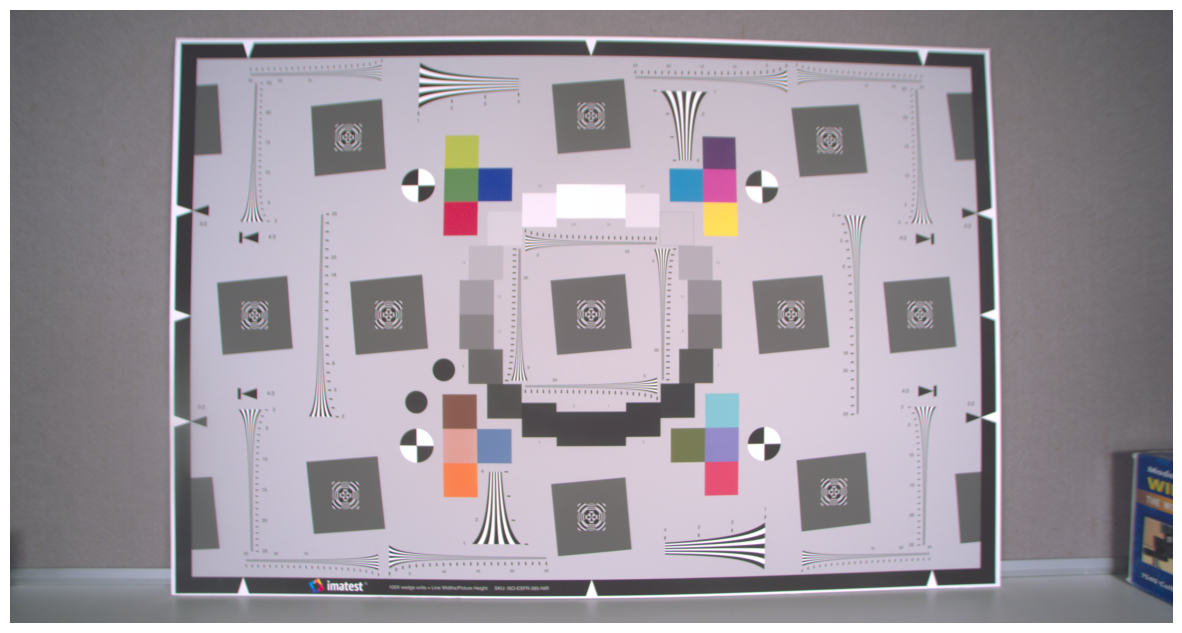

In [ ]:
# apply gamma correction
gamma = 1/2.2

#outputImage   =   (inputImage  /255) ^gamma *255
g_cc_rgb_image = (((cc_rgb_image/255)**gamma)*255).clip(0,255) # apply gamma correction and clip to 0-255
g_cc_rgb_image = g_cc_rgb_image.astype(np.uint8) # cast the image back to 8 bit 

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(g_cc_rgb_image)
plt.axis('off')
plt.show()


## Comments
The gamma adjustment effects the luminance of each pixel to be closer to white. This brightens the image overall and is done using the gamma formula. 

## Apply denoise to image

To apply a denoising filter, multiple options are available. For this implementation, OpenCV's bilateral filter is picked as it reduces noise while preserving edges. A few other options are:
* Gaussian Filter: Blurs the image to reduce noise by averaging pixel values within a defined kernel.
* Median Filter: Replaces each pixel's value with the median value of the pixels in its neighborhood, effective for removing salt-and-pepper noise.
* Non-Local Means Filter: Denoises by averaging pixels with similar patches across the image, preserving textures better than local filters.

(<Axes: title={'center': 'Denoise 25,95,95'}>, None)

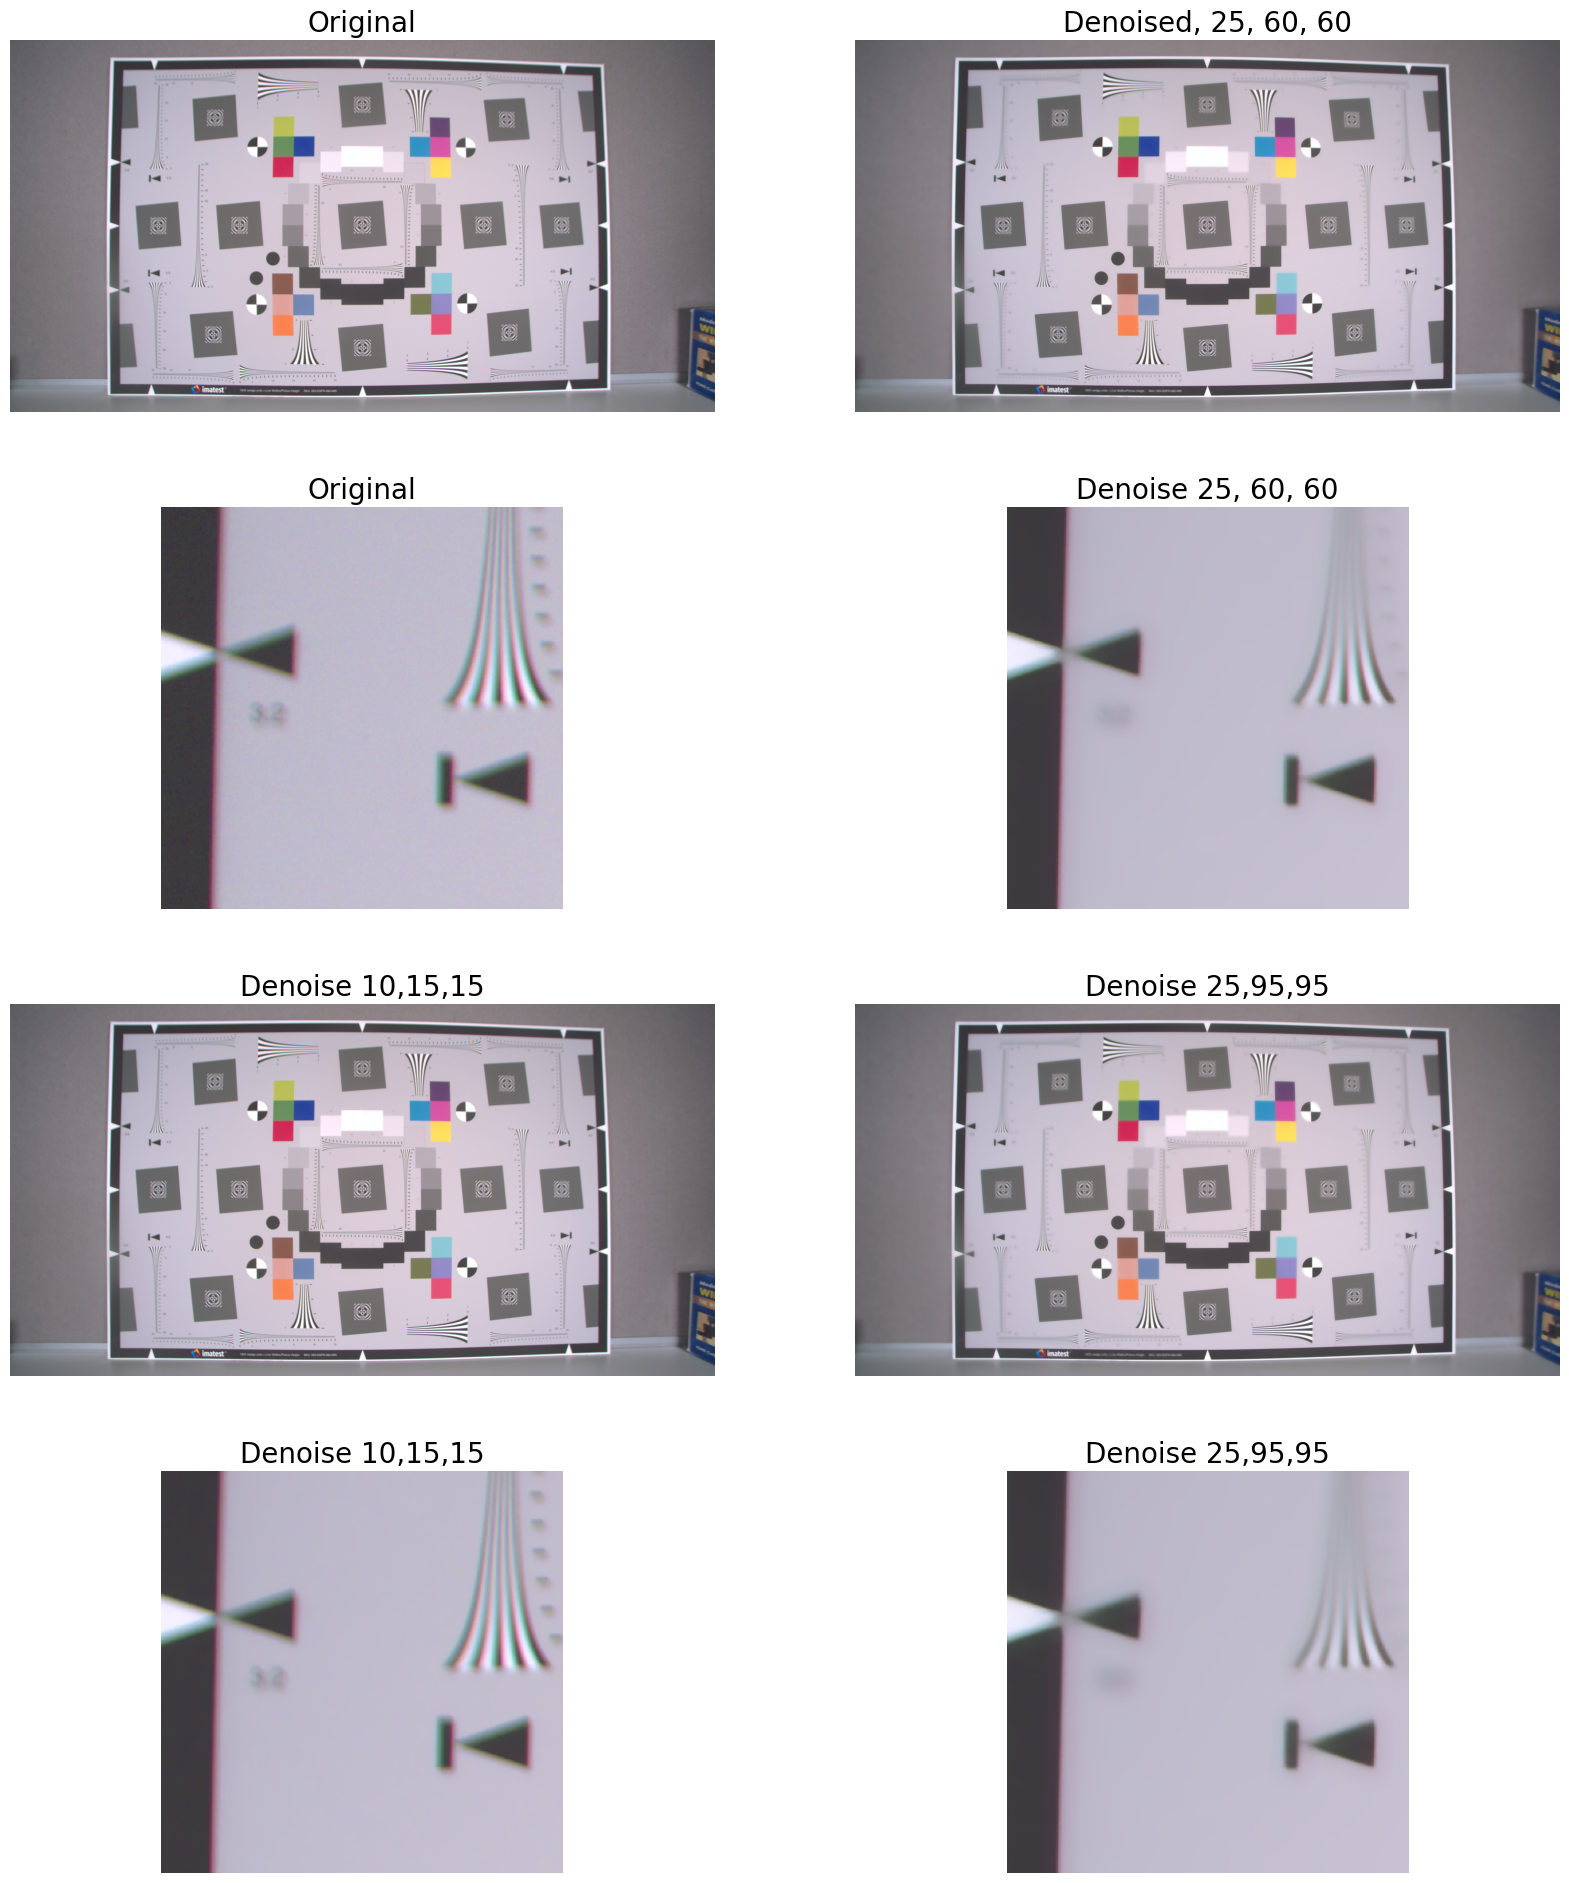

In [ ]:
import matplotlib.pylab as pylab

def plot_image(image, title): # function to simplify plotting the image
    pylab.imshow(image), pylab.title(title, size=20), pylab.axis('off') 

# apply image denoise filtering (bilateral filter)
denoised_img = cv2.bilateralFilter(g_cc_rgb_image, 25, 60, 60)

# experiment with filter coefficients to see the impact on the image.
denoised_img_101515 = cv2.bilateralFilter(g_cc_rgb_image, 10, 15, 15)
denoised_img_259595 = cv2.bilateralFilter(g_cc_rgb_image, 25, 95, 95)

# plot the resulting raw images inline
original_crop = g_cc_rgb_image[600:900, 600:900] 
denoised_crop = denoised_img[600:900, 600:900]
denoised_img_101515_crop = denoised_img_101515[600:900, 600:900] 
denoised_img_259595_crop = denoised_img_259595[600:900, 600:900]

pylab.figure(figsize=(20,24))
pylab.subplot(4,2,1), plot_image(g_cc_rgb_image, 'Original')
pylab.subplot(4,2,2), plot_image(denoised_img, 'Denoised, 25, 60, 60')

pylab.subplot(4,2,3), plot_image(original_crop, 'Original')
pylab.subplot(4,2,4), plot_image(denoised_crop, 'Denoise 25, 60, 60')

pylab.subplot(4,2,5), plot_image(denoised_img_101515, 'Denoise 10,15,15')
pylab.subplot(4,2,6), plot_image(denoised_img_259595, 'Denoise 25,95,95')

pylab.subplot(4,2,7), plot_image(denoised_img_101515_crop, 'Denoise 10,15,15')
pylab.subplot(4,2,8), plot_image(denoised_img_259595_crop, 'Denoise 25,95,95')


## Comments
The bilateral denoise filter is optimal as it removes most texture, noise, and fine details, but preserves large edges without blurring. The output shows a reduction in red/green bleed on edges and cleans up artifacts on the wall behind the photo. 25, 60, and 60 were chosen as the optimal coefficients as they provide ample noise reduction without losing too much fine detail. 2 other inputs can be seen, with 10,15,15 leaving a significant amount of edge noise, and 25,95,95 smearing lines together and making text unreadable. 

## Apply edge enhancement

Edge enhancement is applied to improve the sharpness of pixel edges. A comparison is made between the original and the image enhanced using a Laplacian edge enhancement. 

Laplacian edge enhancement emphasizes the edges in an image by highlighting regions of rapid intensity change through the application of the Laplacian operator, which calculates the second derivative of the image.

(<Axes: title={'center': 'Edge Enhanced'}>, None)

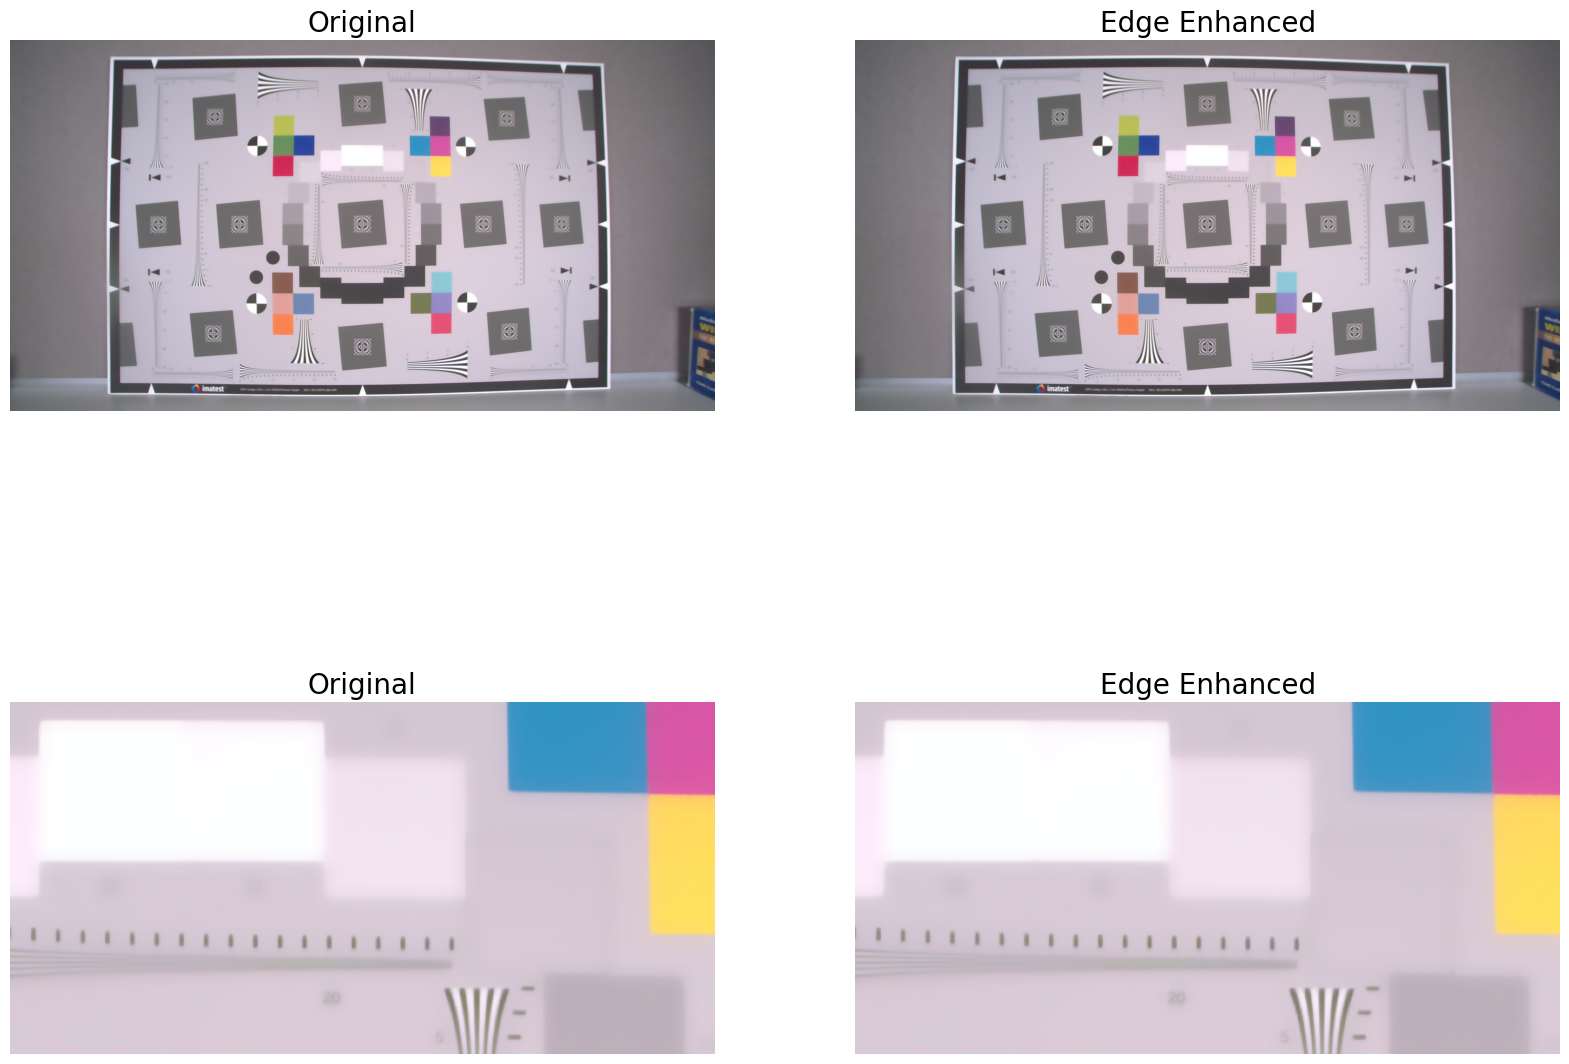

In [ ]:
# Apply edge enhancement
from skimage import filters

# use the skimage filters module to apply edge enhancement
laplace_edges = filters.laplace(denoised_img)

laplace_img = np.clip(denoised_img.astype(np.uint8) + laplace_edges.astype(np.uint8), 0, 255)

# plot the resulting raw file inline
original_crop = denoised_img[600:900, 1900:2500] 
laplace_crop = laplace_img[600:900, 1900:2500]

pylab.figure(figsize=(20,24))
pylab.subplot(3,2,1), plot_image(denoised_img, 'Original')
pylab.subplot(3,2,2), plot_image(laplace_img, 'Edge Enhanced')
pylab.subplot(3,2,3), plot_image(original_crop, 'Original')
pylab.subplot(3,2,4), plot_image(laplace_crop, 'Edge Enhanced')


## Comments 
Comparing the original and edge enhanced image, small changes are noticeable. Edges of color change are more pronounced and blurring is lessened. Laplacian was chosen as it produces thin and accurate edges, but it somewhat let down by the amount of blurring caused by the bilateral filter previous and would have better suited a gaussian blur. Still, the images quality is improved and edges are clearer.  

## Apply contrast enhancement

Finally, contrast enhancement is applied to the image. The Sci-Kit Image exposure library is used to increase image contrast, and three different varying degrees of contrast are displayed. 

(<Axes: title={'center': 'Ridiculous Contrast'}>, None)

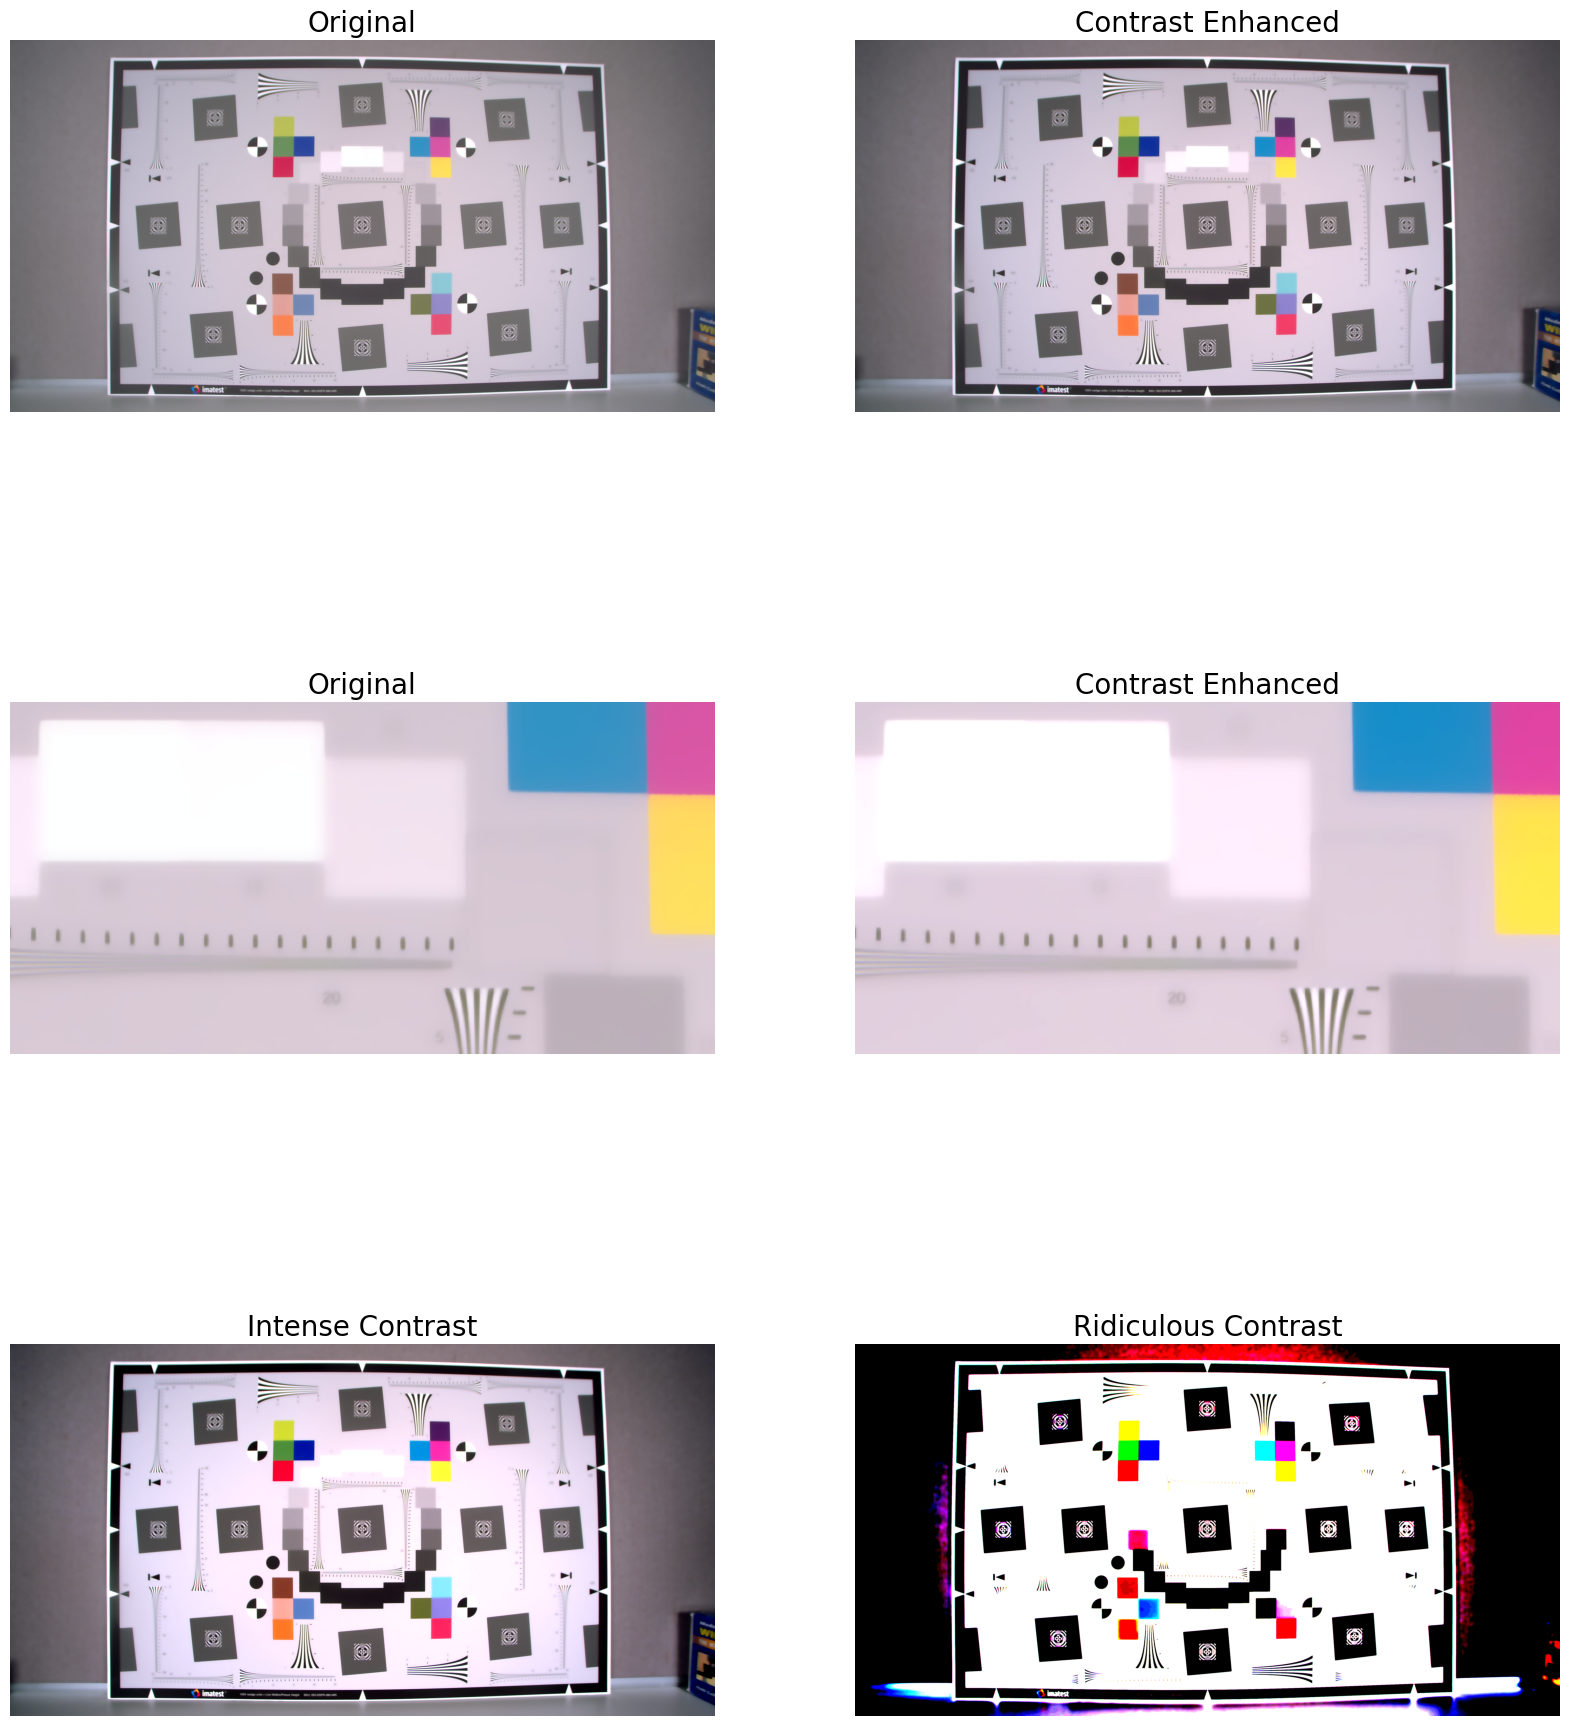

In [ ]:
from skimage import exposure
# increase image contrast.
contrast_img = exposure.rescale_intensity(laplace_img, in_range=(30, 240))
intense_contrast = exposure.rescale_intensity(laplace_img, in_range=(60, 210))
ridiculous_contrast = exposure.rescale_intensity(laplace_img, in_range=(135, 140))

# plot the resulting raw file inline
original_crop = laplace_img[600:900, 1900:2500]
contrast_crop = contrast_img[600:900, 1900:2500]

pylab.figure(figsize=(20,24))
pylab.subplot(3,2,1), plot_image(laplace_img, 'Original')
pylab.subplot(3,2,2), plot_image(contrast_img, 'Contrast Enhanced')
pylab.subplot(3,2,3), plot_image(original_crop, 'Original')
pylab.subplot(3,2,4), plot_image(contrast_crop, 'Contrast Enhanced')
pylab.subplot(3,2,5), plot_image(intense_contrast, 'Intense Contrast')
pylab.subplot(3,2,6), plot_image(ridiculous_contrast, 'Ridiculous Contrast')

## Comments
The 'rescale_intensity' method from the skimage exposure library was chosen for it's simplicity and range parameters. In the first example, the range is 30, 240, meaning that any values below 30 are set as pure black pixels, and any above 240 are set fully white. Pushing much beyond these parameters creates unrealistic effects, as can be seen in the 'Intense' and 'Ridiculous' cases.  

# Conclusions
This project provided hands-on experience in developing a basic Image Signal Processor (ISP) by converting raw sensor data into high-quality, color-corrected images. 
Key takeaways include the importance of each processing step—demosaicing, color correction, denoising, and edge enhancement—in achieving optimal image quality, as well as the significance of parameter tuning in balancing image clarity and natural appearance. The project reinforced a comprehensive understanding of how individual image processing techniques contribute to the overall visual quality of digital images.

In [ ]:
# Compare original image to final image
pylab.figure(figsize=(20,24))
pylab.subplot(1,2,1), plot_image(rgb_image, 'Original')

final_image = contrast_img
pylab.subplot(1,2,2), plot_image(final_image, 'Final Image')

# Save the final image (if desired)
# final_image_path = 'images/chart_final.png'
# cv2.imwrite(final_image_path, final_image)

# Display the final image
final_image = cv2.imread(final_image)
plt.figure(figsize=(15,15))
plt.imshow(final_image)

plt.axis('off')
plt.show()

